# Custom Distance 

This notebook contains all the experiments done with the custom distance 

# Setup locale


In [2]:
# Path su linux
path = './data/Dataset1_BankClients.xlsx'

# Path su windows - comando da inserire 
#path = ' '

# Utility Functions


In [3]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np
import matplotlib.pyplot as plt

def get_optimal_k_voting(X, cluster_results, custom_distances, verbose = False):
    """
    Determine the optimal number of clusters (k) by voting among different metrics.
    
    Parameters:
    - X: Dataset (used for Calinski-Harabasz and Davies-Bouldin scores)
    - cluster_results: Dictionary where keys are k values and values are cluster assignments
    - custom_distances: Precomputed costum distance matrix (used for Silhouette score)
    - print: Whether to print some log 
    
    Returns:
    - optimal_k: The optimal number of clusters based on the median of suggested k values
    """
    
    if not cluster_results:
        raise ValueError("cluster_results cannot be empty")
    
    k_values = list(cluster_results.keys())
    
    # Validate cluster assignments
    for k, assignments in cluster_results.items():
        if len(assignments) != len(X):
            raise ValueError(f"Cluster assignments for k={k} do not match dataset size")
    
    # Get optimal k for each metric
    try:
        ch_optimal = k_values[np.argmax(calinski_harabasz_score(X, cluster_results[k]) for k in k_values)]
        # print("DEBUG: ", ch_optimal)
        # print("Calinski-Harabasz Score (k=3):", calinski_harabasz_score(X, cluster_results[3]))
        # print("Calinski-Harabasz Score (k=4):", calinski_harabasz_score(X, cluster_results[4]))
    except ValueError as e:
        print(f"Warning: Calinski-Harabasz score failed. Skipping. Error: {e}")
        ch_optimal = None
    
    try:
        db_scores = {k: davies_bouldin_score(X, cluster_results[k]) for k in k_values}
        db_optimal = min(db_scores, key=db_scores.get)
        
        # print("DEBUG: ", db_optimal)
        # print("Davies-Bouldin Score (k=3):", db_scores[3])
        # print("Davies-Bouldin Score (k=4):", db_scores[4])
    except ValueError as e:
        print(f"Warning: Davies-Bouldin score failed. Skipping. Error: {e}")
        db_optimal = None

    
    try:
        # Correctly identify the optimal k based on the Silhouette score
        sil_scores = {k: silhouette_score(custom_distances, cluster_results[k], metric='precomputed') for k in k_values}
        sil_optimal = max(sil_scores, key=sil_scores.get)
        
        # print("DEBUG: ", sil_optimal)
        # print("Silhouette Score (k=3):", sil_scores[3])
        # print("Silhouette Score (k=4):", sil_scores[4])
    except ValueError as e:
        print(f"Warning: Silhouette score failed. Skipping. Error: {e}")
        sil_optimal = None
    
    # Collect valid suggestions
    suggestions = [k for k in [ch_optimal, db_optimal, sil_optimal] if k is not None]
    print("Suggestions:", suggestions)
    
    if not suggestions:
        raise ValueError("No valid suggestions from metrics")
    
    # Get median k
    optimal_k = int(np.median(suggestions))
    
    # Print results
    if(verbose):
        print("\nVoting Results:")
        if ch_optimal is not None:
            print(f"Calinski-Harabasz score: {calinski_harabasz_score(X, cluster_results[ch_optimal])}")
        if db_optimal is not None:
            print(f"Davies-Bouldin score: {davies_bouldin_score(X, cluster_results[db_optimal])}")
        if sil_optimal is not None:
            print(f"Silhouette score: {silhouette_score(custom_distances, cluster_results[sil_optimal], metric='precomputed')}")
        print(f"\nFinal decision (median): {optimal_k} clusters")
    
    return optimal_k

def test_different_cluster_kmedoids(X, custom_dist, k_values):
    """
    Test different number of clusters using K-Medoids clustering algorithm.

    Parameters:
    - X: Dataset
    - custom_dist: Precomputed distance matrix
    - k_values: List of k values to test

    Returns:
    - cluster_results: Dictionary where keys are k values and values are cluster assignments
    - silhouette_score: Silhouette score for the optimal k
    """
    cluster_results = {}
    for i in range(len(k_values)):
        k = k_values[i]
        kmedoids = KMedoids(n_clusters=k, random_state=42)
        kmedoids.fit(custom_dist)
        cluster_results[k] = kmedoids.predict(custom_dist)
    
    final_k = get_optimal_k_voting(X, cluster_results, custom_dist)

    return final_k, silhouette_score(custom_dist, cluster_results[final_k], metric='precomputed')

def test_different_cluster_kmeans(X, k_values):
    """
    Test different number of clusters using K-Means clustering algorithm.

    Parameters:
    - X: Dataset
    - k_values: List of k values to test

    Returns:
    - final_k: 
    - silhouette_score: Silhouette score for the optimal k

    """


    cluster_results = {}
    for i in range(len(k_values)):
        k = k_values[i]
        kmeans = KMeans(n_clusters=k, metric='precomputed', random_state=42)
        kmeans.fit(X)
        cluster_results[k] = kmeans.predict(X)
    
    final_k = get_optimal_k_voting(X, cluster_results, X)

    return final_k, silhouette_score(X, cluster_results[final_k], metric='precomputed')

def visualize_cluster(X, clusters, custom_distance):
    """
    Visualize the clustering results in 2D and 3D space using PCA and ICA.
    Parameters:
    - X: Dataset
    - clusters: Cluster assignments
    - custom_distance: Precomputed distance matrix
    """

    # PCA
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    
    # Create subplots for PCA visualization
    fig_pca = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "xy"}, {"type": "scene"}]],
        horizontal_spacing=0.15,
        subplot_titles=["2-D Embedding with PCA", "3-D Embedding with PCA"]
    )
    
    # Add points for each cluster
    unique_clusters = np.unique(clusters)
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow']
    
    for cluster in unique_clusters:
        # Get points in current cluster
        cluster_points = X_pca[clusters == cluster]
        
        # Select color for the cluster
        cluster_color = colors[cluster % len(colors)]
        
        # Add points for 2D scatter
        fig_pca.add_trace(
            go.Scatter(
                x=cluster_points[:, 0],
                y=cluster_points[:, 1],
                mode='markers',
                marker=dict(
                    color=cluster_color,
                    opacity=0.8,
                    size=8
                ),
                name=f'Cluster {cluster} Points',
                showlegend=True,
                legendgroup=f'group{cluster}',
                xaxis='x',
                yaxis='y'
            )
        )
        
        # Add points for 3D scatter
        fig_pca.add_trace(
            go.Scatter3d(
                x=cluster_points[:, 0],
                y=cluster_points[:, 1],
                z=cluster_points[:, 2],
                mode='markers',
                marker=dict(
                    color=cluster_color,
                    opacity=0.8,
                    size=5
                ),
                name=f'Cluster {cluster} Points 3D',
                showlegend=True,
                legendgroup=f'group{cluster}'
            )
        )
    
    # Update 2D layout
    fig_pca.update_xaxes(title_text="Principal Component 1")
    fig_pca.update_yaxes(title_text="Principal Component 2")
    
    # Update 3D layout
    fig_pca.update_layout(
        scene=dict(
            xaxis_title="Principal Component 1",
            yaxis_title="Principal Component 2",
            zaxis_title="Principal Component 3"
        )
    )
    
    ################# ---------------------- ICA ---------------------- #################
    ica = FastICA(n_components=3, random_state=42)
    X_ica = ica.fit_transform(X)
    
    # Create subplots for ICA visualization
    fig_ica = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "xy"}, {"type": "scene"}]],
        horizontal_spacing=0.15,
        subplot_titles=["2-D Embedding with ICA", "3-D Embedding with ICA"]
    )
    
    # Add points for each cluster
    for cluster in unique_clusters:
        # Get points in current cluster
        cluster_points = X_ica[clusters == cluster]
        
        # Select color for the cluster
        cluster_color = colors[cluster % len(colors)]
        
        # Add points for 2D scatter
        fig_ica.add_trace(
            go.Scatter(
                x=cluster_points[:, 0],
                y=cluster_points[:, 1],
                mode='markers',
                marker=dict(
                    color=cluster_color,
                    opacity=0.8,
                    size=8
                ),
                name=f'Cluster {cluster} Points',
                showlegend=True,
                legendgroup=f'group{cluster}',
                xaxis='x',
                yaxis='y'
            )
        )
        
        # Add points for 3D scatter
        fig_ica.add_trace(
            go.Scatter3d(
                x=cluster_points[:, 0],
                y=cluster_points[:, 1],
                z=cluster_points[:, 2],
                mode='markers',
                marker=dict(
                    color=cluster_color,
                    opacity=0.8,
                    size=5
                ),
                name=f'Cluster {cluster} Points 3D',
                showlegend=True,
                legendgroup=f'group{cluster}'
            )
        )
    
    # Update 2D layout
    fig_ica.update_xaxes(title_text="Independent Component 1")
    fig_ica.update_yaxes(title_text="Independent Component 2")
    
    # Update 3D layout
    fig_ica.update_layout(
        scene=dict(
            xaxis_title="Independent Component 1",
            yaxis_title="Independent Component 2",
            zaxis_title="Independent Component 3"
        )
    )
    
    ################# ---------------------- t-SNE ---------------------- #################
    # 2D t-SNE
    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, metric='precomputed', init='random')
    X_tsne_2d = tsne_2d.fit_transform(custom_distance)
    
    # 3D t-SNE
    tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, metric='precomputed', init='random')
    X_tsne_3d = tsne_3d.fit_transform(custom_distance)
    
    # Create subplots for t-SNE visualization
    fig_tsne = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "xy"}, {"type": "scene"}]],
        horizontal_spacing=0.15,
        subplot_titles=["2-D Embedding with t-SNE", "3-D Embedding with t-SNE"]
    )
    
    # Add points for each cluster
    for cluster in unique_clusters:
        # Get points in current cluster for 2D t-SNE
        cluster_points_2d = X_tsne_2d[clusters == cluster]
        # Get points in current cluster for 3D t-SNE
        cluster_points_3d = X_tsne_3d[clusters == cluster]
        
        # Select color for the cluster
        cluster_color = colors[cluster % len(colors)]
        
        # Add points for 2D scatter
        fig_tsne.add_trace(
            go.Scatter(
                x=cluster_points_2d[:, 0],
                y=cluster_points_2d[:, 1],
                mode='markers',
                marker=dict(
                    color=cluster_color,
                    opacity=0.8,
                    size=8
                ),
                name=f'Cluster {cluster} Points',
                showlegend=True,
                legendgroup=f'group{cluster}',
                xaxis='x',
                yaxis='y'
            )
        )
        
        # Add points for 3D scatter
        fig_tsne.add_trace(
            go.Scatter3d(
                x=cluster_points_3d[:, 0],
                y=cluster_points_3d[:, 1],
                z=cluster_points_3d[:, 2],
                mode='markers',
                marker=dict(
                    color=cluster_color,
                    opacity=0.8,
                    size=5
                ),
                name=f'Cluster {cluster} Points 3D',
                showlegend=True,
                legendgroup=f'group{cluster}'
            )
        )
    
    # Update 2D layout
    fig_tsne.update_xaxes(title_text="t-SNE Component 1")
    fig_tsne.update_yaxes(title_text="t-SNE Component 2")
    
    # Update 3D layout
    fig_tsne.update_layout(
        scene=dict(
            xaxis_title="t-SNE Component 1",
            yaxis_title="t-SNE Component 2",
            zaxis_title="t-SNE Component 3"
        )
    )
    
    # Show all visualizations
    fig_pca.show()
    fig_ica.show()
    fig_tsne.show()

# Data loading 

In [4]:
import pandas as pd

# Load data in a DataFrame
data = pd.read_excel(path)

# Let's inspect the first 5 record
print(data.head())
# Drop the column by its actual name (e.g., 'ID' or the actual name of the column)
data = data.drop(columns=['ID'])  # Replace 'ID' with the actual column name to drop

# Test without esg and bankfriend
#data = data.drop(columns=['ESG', 'BankFriend'])

   ID  Age  Gender  Job  Area  CitySize  FamilySize    Income    Wealth  \
0   1   24       1    1     2         2           4  0.668046  0.702786   
1   2   47       1    2     2         3           1  0.858453  0.915043   
2   3   38       0    2     1         2           2  0.926818  0.898316   
3   4   67       0    2     1         2           3  0.538797  0.423180   
4   5   33       0    2     1         3           1  0.806659  0.731404   

       Debt    FinEdu       ESG   Digital  BankFriend  LifeStyle    Luxury  \
0  0.262070  0.741853  0.483684  0.698625    0.618259   0.607877  0.897369   
1  0.730430  0.859423  0.537167  0.959025    0.785936   0.862271  0.913729   
2  0.441272  0.485953  0.649434  0.750265    0.699725   0.755404  0.765199   
3  0.600401  0.493144  0.533829  0.590165    0.675353   0.334432  0.517209   
4  0.831449  0.856286  0.784940  0.710026    0.758793   0.908878  0.611610   

     Saving  Investments  
0  0.283222            1  
1  0.821590            3  

# Data Preprocessing

In [5]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np

# Specify categorical variables
categorical_columns = ['Gender', 'Job', 'Area', 'CitySize', 'Investments']
#categorical_columns = ['Gender', 'Job', 'Area', 'CitySize']


# Split variables
numerical_features = data.drop(columns=categorical_columns)  # Exclude categorical variables
categorical_features = data[categorical_columns]  # Select categorical variables

# Convert categorical in typ 'category' (for OneHotEncoder)
categorical_features = categorical_features.astype('category')

# Normalize numerical variables
scaler = MinMaxScaler()
X_num = scaler.fit_transform(numerical_features)

# One-hot encoding categorical variables
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')  # Dummy encoding - set 1 feature to all 0s - ignoring unknwown values
X_cat = encoder.fit_transform(categorical_features).toarray()  # Convert into a dense matrix

# Concatenation of numerical and categorical variables
X = np.hstack((X_num, X_cat))

# Summary of the dataset
print("Numerical Features Shape:", X_num.shape)
print("Categorical Features Shape:", X_cat.shape)
print("Combined Features Shape:", X.shape)


Numerical Features Shape: (5000, 12)
Categorical Features Shape: (5000, 11)
Combined Features Shape: (5000, 23)


# Custom Distance

In [6]:
import numpy as np
from scipy.spatial.distance import cdist, mahalanobis
from scipy.linalg import inv

def vectorized_mahalanobis(X_num, inv_cov_matrix):
    """
    Vectorized Mahalanobis distance calculation
    Returns square matrix of pairwise distances
    """
    # Compute differences between all pairs of points
    diff = X_num[:, np.newaxis] - X_num[np.newaxis, :]
    
    # Matrix multiplication approach for Mahalanobis distance
    return np.sqrt(np.sum(diff @ inv_cov_matrix * diff, axis=-1))

def vectorized_euclidean(X_num):
    """
    Vectorized Mahalanobis distance calculation
    Returns square matrix of pairwise distances
    """
    # Compute differences between all pairs of points
    diff = X_num[:, np.newaxis] - X_num[np.newaxis, :]
    
    # Matrix multiplication approach for Mahalanobis distance
    return np.sqrt(np.sum(diff * diff, axis=-1))

def vectorized_overlap(X_cat):
    """
    Vectorized overlap distance calculation
    Returns square matrix of pairwise distances
    """
    # Compute minimum between all pairs of points
    min_size = np.minimum(
        X_cat.sum(axis=1)[:, np.newaxis],
        X_cat.sum(axis=1)[np.newaxis, :]
    )
    
    # Compute intersection sum for all pairs
    intersection = np.minimum(X_cat[:, np.newaxis], X_cat[np.newaxis, :]).sum(axis=-1)
    
    # Handle division by zero
    mask = min_size > 0
    result = np.ones_like(min_size, dtype=float)
    result[mask] = 1 - intersection[mask] / min_size[mask]

    # Set diagonal to zero
    np.fill_diagonal(result, 0)
    
    return result

# # Drop age to numerical features
# X_num = np.delete(X_num, 0, axis=1)

# # Discretize Age 
# age = data['Age']
# age_bins = [0, 35, 65]
# age_labels = [0, 1, 2]
# # full of zero 
# age_discretized = np.zeros((len(age), 1))
# for i in range(len(age)):
#     for j in range(len(age_bins)):
#         if age[i] >= age_bins[j]:
#             age_discretized[i] = age_labels[j]
#             break

# Compute covariance matrix and its inverse
cov_matrix = np.cov(X_num.T)
inv_cov_matrix = inv(cov_matrix)

# Calculate distances
num_dist = vectorized_mahalanobis(X_num, inv_cov_matrix)
cat_dist = vectorized_overlap(X_cat)

# Normalize distances numerically
num_dist = num_dist/np.max(num_dist)

In [7]:
def optimize_weights_cd(weights, X, num_dist, cat_dist):
    """
    Optimize the weights for the custom distance matrix.

    Parameters:
    - weights: List of weights to test
    - X: Dataset
    - num_dist: Numerical distance matrix
    - cat_dist: Categorical distance matrix

    Returns:
    - best_weights: The best weights
    - best_k: The optimal number of clusters
    - best_sil: The Silhouette score for the optimal k
    """

    sil_scores = {}
    k_best = {}

    for i in range(len(weights)):
        # test different weights
        w_num = weights[i]
        w_cat = 1 - w_num
        custom_dist = w_num*num_dist + w_cat*cat_dist
        print(f'Testing - w_num = {w_num}, w_cat = {w_cat}')
        
        # check goodness of the weights
        k_best[weights[i]], sil_scores[weights[i]] = test_different_cluster_kmedoids(X, custom_dist, [2, 3, 4])

    # Get the best weights
    best_weights = max(sil_scores, key=sil_scores.get)
    print(f'Best weights: {best_weights}')
    print(f'Best k: {k_best[best_weights]}')
    print(f'Silhouette score: {sil_scores[best_weights]}')

    return best_weights, k_best[best_weights], sil_scores[best_weights]

best_weights, best_k, best_sil = optimize_weights_cd([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], X, num_dist, cat_dist)


Testing - w_num = 0.1, w_cat = 0.9
Suggestions: [2, 2, 2]
Testing - w_num = 0.2, w_cat = 0.8
Suggestions: [2, 3, 3]
Testing - w_num = 0.3, w_cat = 0.7
Suggestions: [2, 3, 3]
Testing - w_num = 0.4, w_cat = 0.6
Suggestions: [2, 4, 2]
Testing - w_num = 0.5, w_cat = 0.5
Suggestions: [2, 4, 2]
Testing - w_num = 0.6, w_cat = 0.4
Suggestions: [2, 4, 2]
Testing - w_num = 0.7, w_cat = 0.30000000000000004
Suggestions: [2, 4, 2]
Testing - w_num = 0.8, w_cat = 0.19999999999999996
Suggestions: [2, 3, 2]
Testing - w_num = 0.9, w_cat = 0.09999999999999998
Suggestions: [2, 4, 2]
Best weights: 0.1
Best k: 2
Silhouette score: 0.41391760935570326


# Clustering

In [8]:
# Compute the best distance matrix
custom_dist = best_weights*num_dist + (1 - best_weights)*cat_dist

# Did K-Medoids clustering using good data achieved
kmedoids = KMedoids(n_clusters=best_k, random_state=42)
kmedoids.fit(custom_dist)
clusters = kmedoids.predict(custom_dist)

# Silhoutte score
sil_score = silhouette_score(custom_dist, clusters, metric='precomputed')
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.41391760935570326


# Plotting

In [9]:
visualize_cluster(X, clusters, custom_dist)

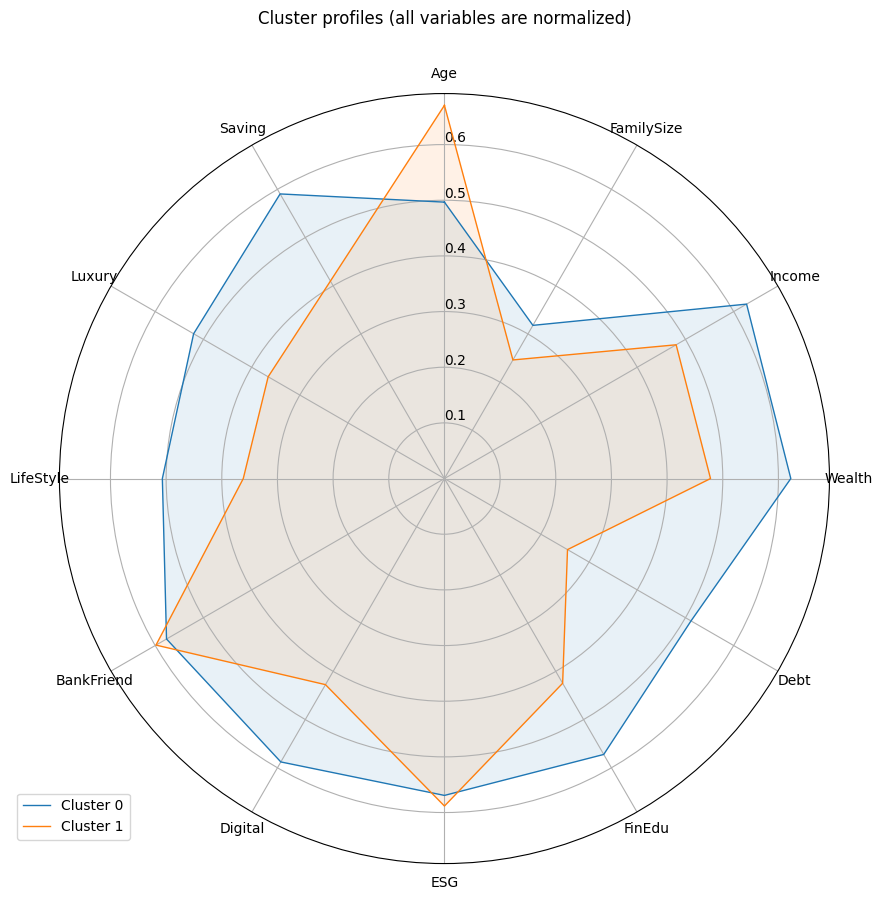

In [10]:
def plot_cluster_radar(data):
    # Create a copy of the data for normalization
    plot_data = data.copy()

    # Normalize all numerical variables using MinMaxScaler
    scaler = MinMaxScaler()
    plot_data[numerical_features.columns] = scaler.fit_transform(plot_data[numerical_features.columns])

    # Calculate mean values for each numerical variable by cluster
    cluster_means = plot_data.groupby('Cluster')[numerical_features.columns].mean()

    # Set up the radar chart
    categories = numerical_features.columns
    num_vars = len(categories)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    # Plot for each cluster
    for cluster in range(data['Cluster'].nunique()):
        values = cluster_means.loc[cluster].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {cluster}')
        ax.fill(angles, values, alpha=0.1)

    # Set chart properties
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    plt.xticks(angles[:-1], categories)
    ax.set_title("Cluster profiles (all variables are normalized)", y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.show()

# Radar chart
data_with_clusters = data.copy()
data_with_clusters['Cluster'] = clusters

plot_cluster_radar(data_with_clusters)

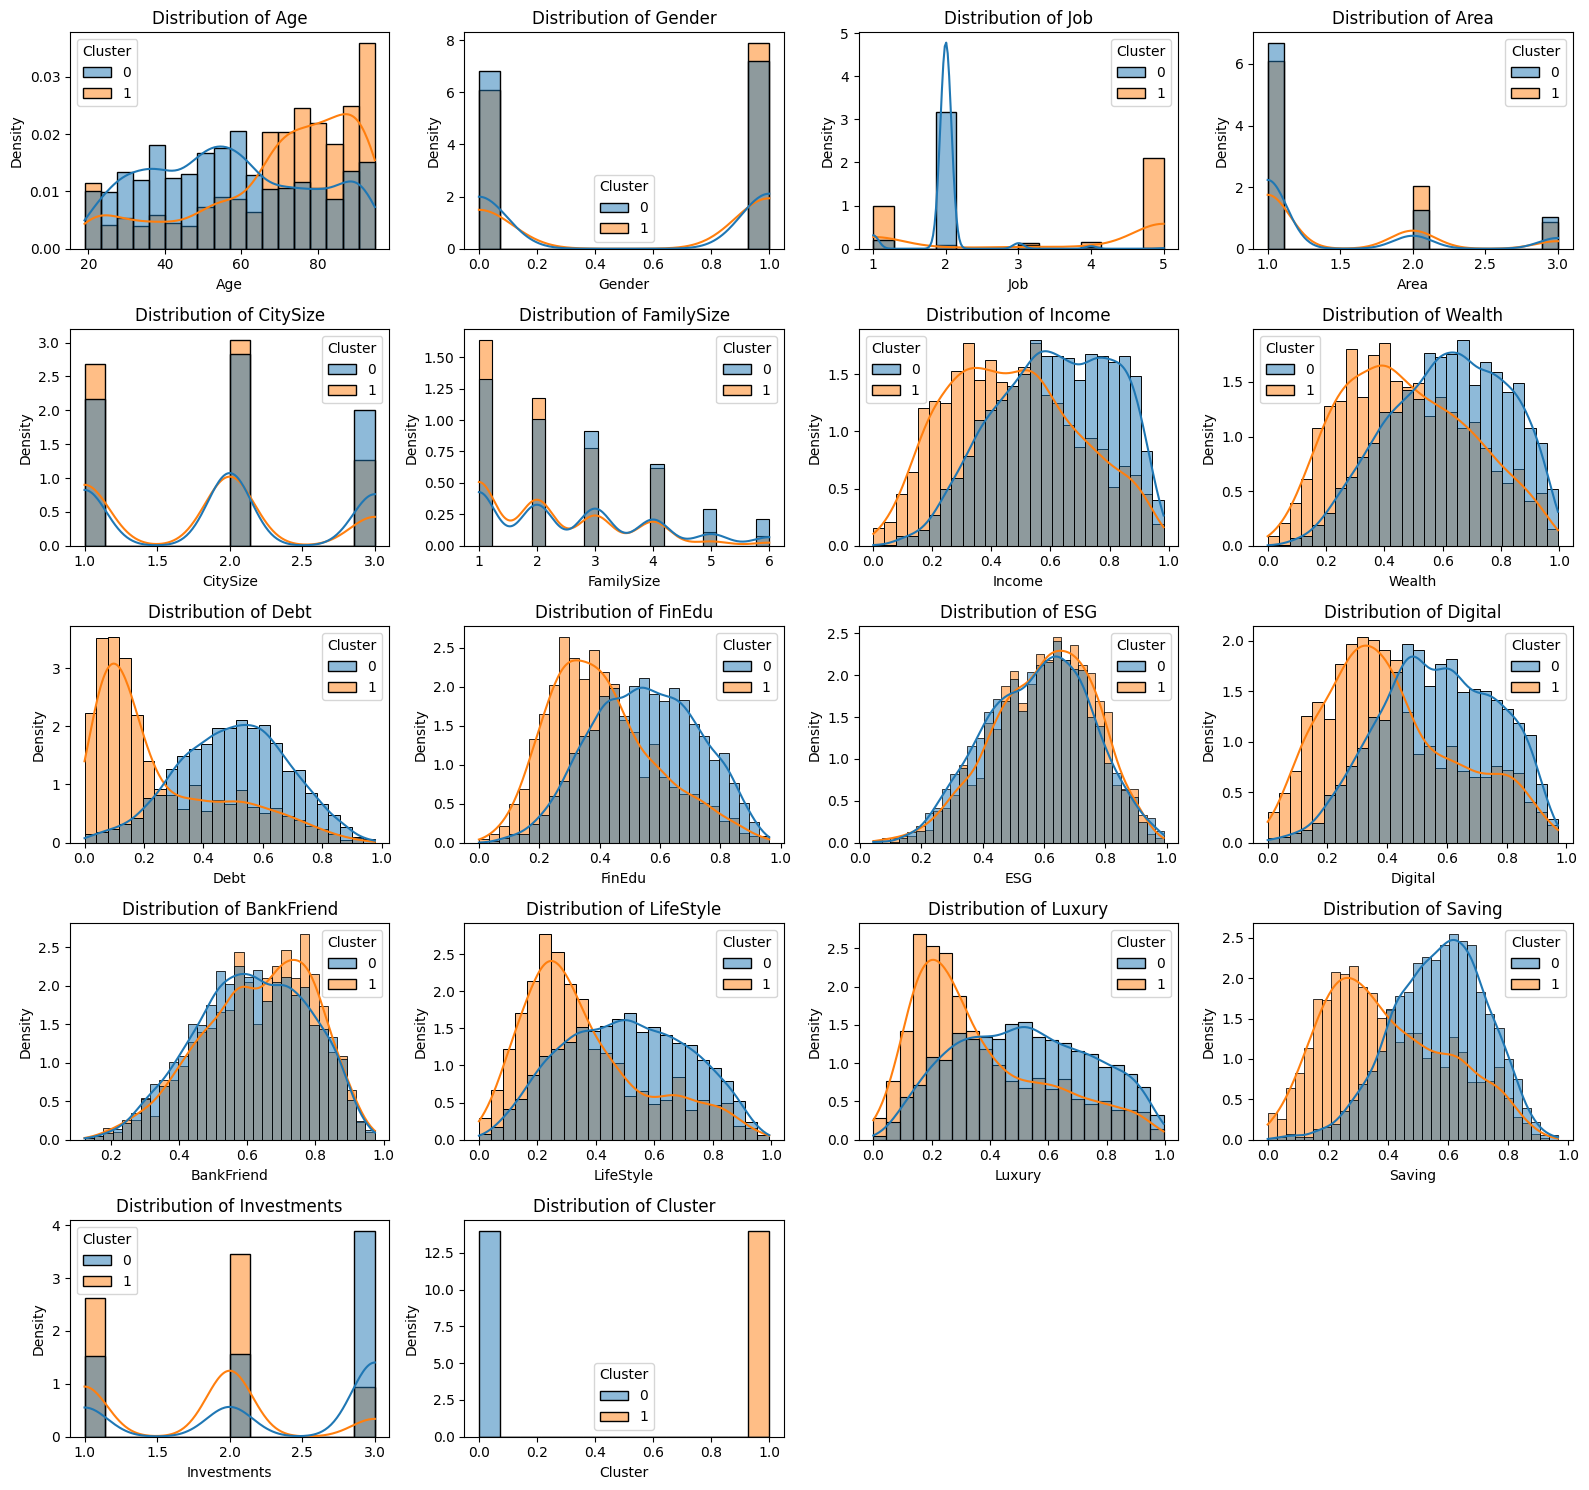

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

def plot_cluster_histograms(data_with_clusters):
    """
    Creates separate histogram plots for all variables in the dataset,
    colored by cluster assignments.
    
    Parameters:
        data_with_clusters : DataFrame
            Dataset containing variables and Cluster assignments
            
    Returns:
        Figure object
    """
    # Define the variables we want to plot
    variables = data_with_clusters.columns.values
    
    # Calculate optimal grid dimensions
    n_vars = len(variables)
    n_cols = min(4, n_vars)  # Maximum 4 columns
    n_rows = math.ceil(n_vars / n_cols)  # Calculate needed rows
    
    # Create figure with calculated dimensions
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = axes.ravel()  # Flatten the array for easier indexing
    
    # Plot each variable
    for var, ax in zip(variables, axes):
        sns.histplot(
            data=data_with_clusters,
            x=var,
            hue='Cluster',
            kde=True,
            stat='density',
            common_norm=False,
            ax=ax
        )
        ax.set_title(f'Distribution of {var}')
    
    # Remove empty subplots if needed
    if len(variables) < n_rows * n_cols:
        for i in range(len(variables), n_rows * n_cols):
            fig.delaxes(axes[i])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    return fig

# Example usage:
fig = plot_cluster_histograms(data_with_clusters)

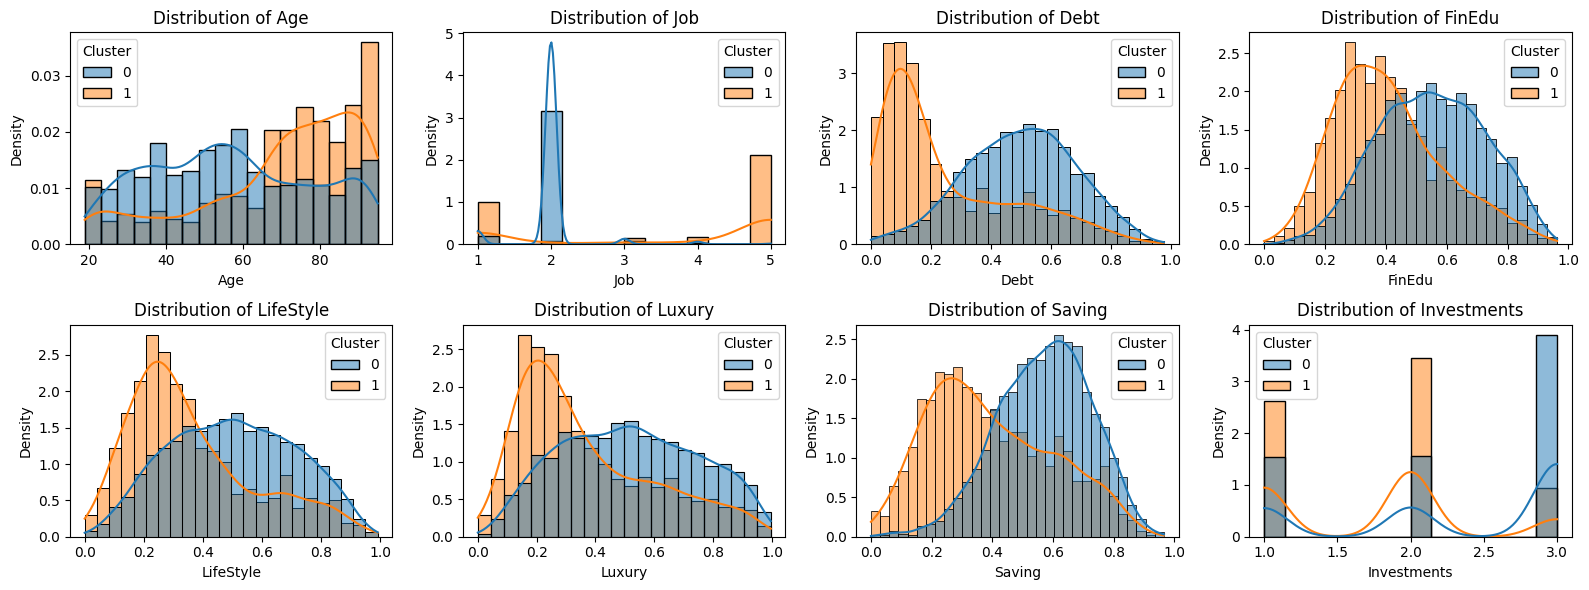

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

def plot_cluster_histograms(data_with_clusters):
    """
    Creates separate histogram plots for all variables in the dataset,
    colored by cluster assignments.
    
    Parameters:
        data_with_clusters : DataFrame
            Dataset containing variables and Cluster assignments
            
    Returns:
        Figure object
    """
    # Define the variables we want to plot
    variables = ["Age", "Job", "Debt", "FinEdu", "LifeStyle", "Luxury", "Saving", "Investments"]
    
    # Calculate optimal grid dimensions
    n_vars = len(variables)
    n_cols = min(4, n_vars)  # Maximum 4 columns
    n_rows = math.ceil(n_vars / n_cols)  # Calculate needed rows
    
    # Create figure with calculated dimensions
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = axes.ravel()  # Flatten the array for easier indexing
    
    # Plot each variable
    for var, ax in zip(variables, axes):
        sns.histplot(
            data=data_with_clusters,
            x=var,
            hue='Cluster',
            kde=True,
            stat='density',
            common_norm=False,
            ax=ax
        )
        ax.set_title(f'Distribution of {var}')
    
    # Remove empty subplots if needed
    if len(variables) < n_rows * n_cols:
        for i in range(len(variables), n_rows * n_cols):
            fig.delaxes(axes[i])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    return fig

# Example usage:
fig = plot_cluster_histograms(data_with_clusters)